In [1]:
import numpy as np
import matplotlib.pyplot as plt

# a


In [2]:
def u(x: np.floating | np.ndarray, epsilon: np.floating) -> np.ndarray:
    def temp_func(x: np.floating | np.ndarray) -> np.floating | np.ndarray:
        return np.exp(-x / epsilon)

    temp = temp_func(np.float16(1))

    return np.where(
        np.logical_or(x == 0, x == 1),
        np.float16(0),
        x - (temp_func(1 - x) - temp) / (1 - temp),
    )


u(np.array([0, 0.5, 1]), np.float16(1))

array([0.        , 0.12235333, 0.        ])

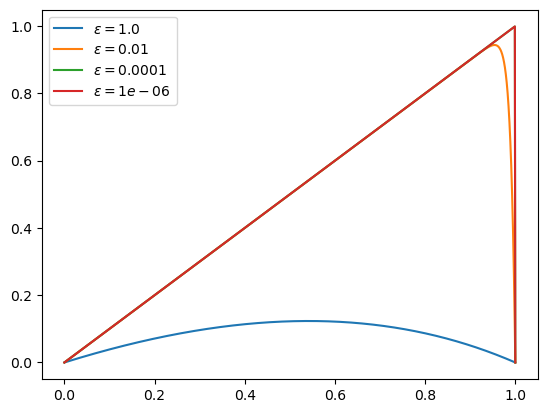

In [3]:
epsilons = np.array([10**-i for i in [0, 2, 4, 6]])
x = np.linspace(0, 1, 1000)
for epsilon in epsilons:
    plt.plot(x, u(x, epsilon), label=f"$\\epsilon = {epsilon}$")

plt.legend()

plt.savefig("a.png", dpi=300)

# c


In [4]:
def gen_A(n: int) -> np.ndarray:
    """generate the matrix A of the linear system of equations Au=p"""
    n = n - 1
    A = np.zeros((n, n))
    for i in range(n):
        A[i, i] = 2
        if i > 0:
            A[i, i - 1] = -1
        if i < n - 1:
            A[i, i + 1] = -1
    return A * ((n + 1) ** 2)


gen_A(5)

array([[ 50., -25.,   0.,   0.],
       [-25.,  50., -25.,   0.],
       [  0., -25.,  50., -25.],
       [  0.,   0., -25.,  50.]])

In [5]:
def f(x: np.floating | np.ndarray, epsilon: np.floating, h):
    """the right-hand side of the differential equation"""
    return ((u(x + h, epsilon) - u(x - h, epsilon)) / (2 * h) - 1) / epsilon

In [6]:
def gen_real_val(
    n: int,
    h,
    a,
    epsilon: np.float32,
) -> np.ndarray:
    """generate the values of the function u at the points x_i shape (n-1, 1)"""
    y = np.zeros(n - 1)
    for i in range(n - 1):
        y[i] = -u(a + (i + 1) * h, epsilon) * (h**2)
    return y.reshape((n - 1, 1))

In [7]:
def gen_est_val(
    n: int,
    h,
    a,
    epsilon: np.float32,
) -> np.ndarray:
    """generate the values of the function f at the points x_i shape (1, n-1)"""
    y = np.zeros(n - 1)
    for i in range(n - 1):
        y[i] = -f(a + (i + 1) * h, epsilon, h) * (h**2)
    return y

In [8]:
def gen_p(n: int, f_ls: np.ndarray, a, b) -> np.ndarray:
    """generate the vector p of the linear system of equations Au=p"""
    p = np.zeros((n - 1, 1))
    p[0] = f_ls[0] + a * (n**2)
    for i in range(1, n - 2):
        p[i] = f_ls[i]
    p[n - 2] = f_ls[n - 2] + b * (n**2)
    return p.reshape(n - 1, 1)

In [9]:
def gen_matrix(n, h, a, b, epsilon):
    """
    generate the matrix A and the vector p of the linear system of equations Au=p
    Parameters:
    n: number of intervals
    h: step size
    a: u(0)
    b: u(1)
    """
    A = gen_A(n)
    f_ls = gen_est_val(n, h, a, epsilon)
    p = gen_p(n, f_ls, a, b)
    return A, p

# d


In [10]:
def solve(
    n: int, h: np.floating, a: np.floating, b: np.floating, epsilon: np.floating
) -> np.ndarray:
    """
    solve the linear system of equations Au=p
    Parameters:
    n: number of intervals
    h: step size
    a: u(0)
    b: u(1)
    """
    A, p = gen_matrix(n, h, a, b, epsilon)

    assert A.shape == (n - 1, n - 1)
    assert p.shape == (n - 1, 1)

    return np.linalg.solve(A, p)

In [11]:
def gen_error(n, h, a, b, epsilon):
    """
    generate the error of the solution
    Parameters:
    n: number of intervals
    h: step size
    a: u(0)
    b: u(1)
    """
    y_est = solve(n, h, a, b, epsilon)
    y_real = gen_real_val(n, h, a, epsilon)

    assert y_est.shape == y_real.shape

    err = np.sqrt(np.sum((y_real - y_est) ** 2) / (n - 1))
    return err

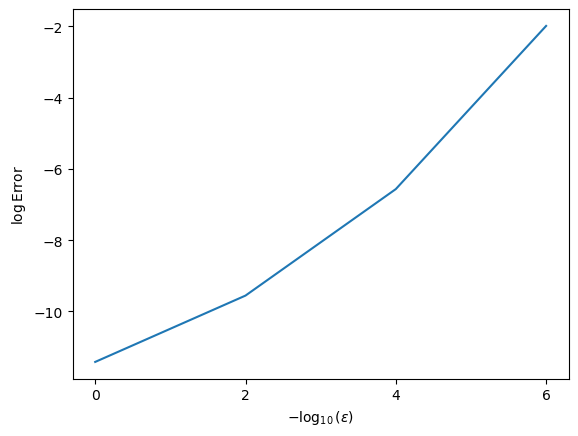

In [12]:
a = np.float16(0)
b = np.float16(0)
n = 128
h = np.float64(1 / n)

epsilons = np.array([10**-i for i in [0, 2, 4, 6]])

errs = [gen_error(n, h, a, b, epsilon) for epsilon in epsilons]

plt.plot([0, 2, 4, 6], np.log(errs))
plt.xlabel(r"$-\log_{10}(\epsilon)$")
plt.xticks([0, 2, 4, 6])
plt.ylabel(r"$\log\text{Error}$")

plt.savefig("d.png", dpi=300)